#### Naive Bayes (03.04 - 2.4.4)

- p(x1|y) X p(x2|y) .... p(xp|y) 구하는 부분

In [1]:
import numpy as np 
import pandas as pd

In [2]:
data = pd.read_csv('weather.nominal.csv')
data

,outlook,temperature,humidity,windy,play
0,overcast,hot,high,False,yes
1,overcast,cool,normal,True,yes
2,overcast,mild,high,True,yes
3,overcast,hot,normal,False,yes
4,rainy,mild,high,False,yes
5,rainy,cool,normal,False,yes
6,rainy,cool,normal,True,no
7,rainy,mild,normal,False,yes
8,rainy,mild,high,True,no
9,sunny,hot,high,False,no


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   outlook       14 non-null     object
 1    temperature  14 non-null     object
 2    humidity     14 non-null     object
 3    windy        14 non-null     bool  
 4    play         14 non-null     object
dtypes: bool(1), object(4)
memory usage: 590.0+ bytes


In [4]:
data.columns

Index(['outlook', ' temperature', ' humidity', ' windy', ' play'], dtype='object')

In [5]:
data.columns.values

array(['outlook', ' temperature', ' humidity', ' windy', ' play'],
      dtype=object)

In [6]:
# 컬럼명 앞뒤 공백 제거

names = pd.Series(data.columns.values)
names = names.str.strip()

# 확인
for name in names:
    print(name)


outlook
temperature
humidity
windy
play


In [7]:
data.columns = names
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   outlook      14 non-null     object
 1   temperature  14 non-null     object
 2   humidity     14 non-null     object
 3   windy        14 non-null     bool  
 4   play         14 non-null     object
dtypes: bool(1), object(4)
memory usage: 590.0+ bytes


In [8]:
data['windy'] = data['windy'].astype('str')
data.dtypes

outlook        object
temperature    object
humidity       object
windy          object
play           object
dtype: object

In [9]:
tabs = []
for col in data.columns[:-1]:
    temp = pd.crosstab(data['play'], data[col]) # play(y)에 따른 각 빈도수 산출
    tabs.append(temp)

joined_tab = pd.concat(tabs, axis=1)    # axis=1로 결합
joined_tab

,overcast,rainy,sunny,cool,hot,mild,high,normal,False,True
play,,,,,,,,,,
no,0,2,3,1,2,2,4,1,2,3
yes,4,3,2,3,2,4,3,6,6,3


In [10]:
# no : y = 0일 때, overcast ~ True : x1, x2, ...xp = (xi교y)
# yes : y = 1일 때, overcast ~ True : x1, x2, ...xp = (xi교y)

In [11]:
freqY = data.groupby('play').agg('size')        # groupby -> 알파벳순 정렬
freqY

play
no     5
yes    9
dtype: int64

In [12]:
data.play.value_counts()

yes    9
no     5
Name: play, dtype: int64

- p(x|y)= p(x교y)/p(y)
- 전체 crosstab을 play(yes/no) 빈도수로 나누기

In [13]:
# crosstab : 2Xn - play빈도 : 2
# np brodcasting : 마지막 축(axis) 같거나, 한쪽이 1이어야 함 

# play 빈도수를 2X1 로

In [14]:
freqY.to_frame()        # pd.Series를 df로 변환 

,0
play,
no,5
yes,9


In [15]:
freqY.shape, freqY.to_frame().shape

((2,), (2, 1))

In [16]:
Xprob = joined_tab / freqY.to_frame().values
Xprob

,overcast,rainy,sunny,cool,hot,mild,high,normal,False,True
play,,,,,,,,,,
no,0.000000,0.400000,0.600000,0.200000,0.400000,0.400000,0.800000,0.200000,0.400000,0.600000
yes,0.444444,0.333333,0.222222,0.333333,0.222222,0.444444,0.333333,0.666667,0.666667,0.333333


In [17]:
# or 
joined_tab / freqY.values.reshape((-1,1))

,overcast,rainy,sunny,cool,hot,mild,high,normal,False,True
play,,,,,,,,,,
no,0.000000,0.400000,0.600000,0.200000,0.400000,0.400000,0.800000,0.200000,0.400000,0.600000
yes,0.444444,0.333333,0.222222,0.333333,0.222222,0.444444,0.333333,0.666667,0.666667,0.333333


In [18]:
# 스무딩 파라메터(Naive 추정 튜닝방법) alpha 
# : 모든 데이터 빈도수(crosstab)에 1을 주고 시작 / 성급한 확정결론 피할 수 있음 

In [19]:
# P(y) = prior 
yprob = freqY / freqY.sum()
yprob

play
no     0.357143
yes    0.642857
dtype: float64

In [20]:
# or 
data.play.value_counts(normalize=True)[::-1]    # normalize=True : 빈도/전체 비율 한번에

no     0.357143
yes    0.642857
Name: play, dtype: float64

#### What we want to know 
- 날씨 : Sunny, Mild, High, True일 때, 골프를 칠(Yes) 말(No)

- P(Sunny, Mild, High, True|Yes)과
- P(Sunny, Mild, High, True|No) 비교,
- 큰 값 선택

- naive 베이지안 분류기는 모든 변수 사건을 독립으로 가정
- P(Sunny, Mild, High, True|Yes) = P(Sunny|Yes) × ...P(True|Yes)

In [21]:
Xprob   # ㅠP(Xi|y)

,overcast,rainy,sunny,cool,hot,mild,high,normal,False,True
play,,,,,,,,,,
no,0.000000,0.400000,0.600000,0.200000,0.400000,0.400000,0.800000,0.200000,0.400000,0.600000
yes,0.444444,0.333333,0.222222,0.333333,0.222222,0.444444,0.333333,0.666667,0.666667,0.333333


In [22]:
yprob   # P(y)

play
no     0.357143
yes    0.642857
dtype: float64

In [23]:
prob = yprob.copy()
for col in ["sunny", "mild", "high", "True"]:
    prob *= Xprob[col].values
    
prob                                        #  prob.score가 정확한 표현 

play
no     0.041143
yes    0.007055
dtype: float64

In [24]:
yprob.index[prob.argmax()]

'no'

In [25]:
# 찐 확률
prob / prob.sum()

play
no     0.85363
yes    0.14637
dtype: float64

- [Quiz] 위 Xprob과 yprob을 이용하여 logprob을 계산해보자.

- log p(y=0) ~ Sigma log P(Xi|y=0) + log P(y=0)

In [26]:
# margina.prob(분모)는 공통, 고려하지 X

In [27]:
logprob = np.log(yprob)

for col in ["sunny", "mild", "high", "True"]:
    logprob += np.log(Xprob[col].values)

print(yprob.index[logprob.argmax()])
logprob

no


play
no    -3.190705
yes   -4.954065
dtype: float64

In [28]:
# no값이 yes 값보다 크므로 no값으로 예측O

In [29]:
# ?? 스무딩 어디서 어떻게 해야 하는거니 ? 


#### 1) 다항분포 나이브 베이즈 (2.4.4(1))

In [30]:
# multinomial Variable 
# 빈도표가 존재하는 데이터 입력

# alpha : smoothing parameter (=1)
# fit_prior : 사전확률을 학습할 것인가? (=True)
# Class_prior : 데이터 학습 않고(False) 경험적인 값을 넣을 때 (=None)

In [31]:
from sklearn.naive_bayes import MultinomialNB
multinomial_model = MultinomialNB()
multinomial_model

MultinomialNB()

In [32]:
data = data.apply(lambda s: s.astype('category'))
data.dtypes

outlook        category
temperature    category
humidity       category
windy          category
play           category
dtype: object

In [33]:
# 학습시키면 error 발생
# multinomial_model.fit(data.iloc[:,:-1], data.iloc[:,-1])
# 데이터 one-hot 인코딩 필요( 숫자 -> 문자 변환) 

In [34]:
try:
    multinomial_model.fit(data.iloc[:,:-1], data.iloc[:,-1])
except Exception as e:
    print(e)

    # 필요한 에러부분만 가져오기 

Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'


C:\Users\CPB06GameN\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [35]:
# one-hot encoding없이 category 데이터로 작업할 경우, 잘못된 결과를 발생시킨다.
for i in range(data.shape[1]-1):
    lookup = {}
    for j, k in enumerate(np.unique(data.iloc[:,i])):
        lookup[k] = j
    data.iloc[:, i] = data.iloc[:, i].map(lookup)
    
data.head()

,outlook,temperature,humidity,windy,play
0,0,1,0,0,yes
1,0,0,1,1,yes
2,0,2,0,1,yes
3,0,1,1,0,yes
4,1,2,0,0,yes


#### spam.csv : 정상/ 스팸 트윗 구분하는 학습데이터

In [36]:
# 첫 줄은 빈줄 (v1, v2,,,) -> 이게 빈줄인가? 
# ham, (tweet)
# spam, (tweet)

# 콤마 앞으로 y값, 뒤 tweet, 나머지는 버림 

In [37]:
import numpy as np 
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

In [38]:
url = "https://raw.githubusercontent.com/AndersonJo/text-classification-tutorial/master/spam.csv"
data = pd.read_csv(url, encoding='latin-1', usecols=(0, 1), names=('class', 'text'), skiprows=1)
display(data.head())
display(data.groupby('class').describe())

# latin-1 : 아스키 코드 남는 부분에 인코딩
# display  -> df 출력 옵션 / 왜 굳이?? 

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

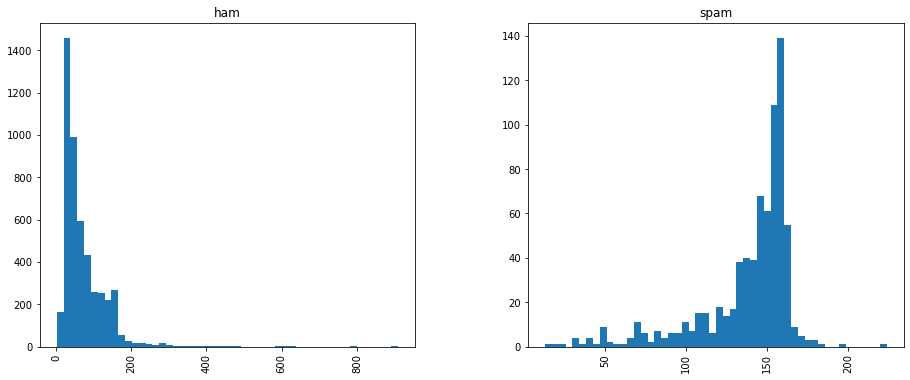

In [40]:
# 데이터(문장)의 길이

data['length'] = data['text'].apply(len)
ax = data.hist('length', by='class', bins=50, figsize=(15, 6))

# 왜 len(data['text'])는 중앙 일직선 그래프 이상하게 나올까? 
# len() vs ~.apply(len)
# apply : 컬럼 단위로 적용하는 함수 (열기준 다양한 함수를 적용)


#### Tokenizing 

- 자연어 처리시 분석단위 만들기
- 자소, **단어, 문장

- 관심있는 단어들의 빈도표 생성

- 구두점 (! ' ,) punctuation 삭제 
- 이후 stopwords (a the of at..)데이터분류에 의미없는 문자 삭제 

In [41]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CPB06GameN\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [42]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [53]:
s = " I'am a boy! "
nopunc = [char for char in s if char not in string.punctuation] # 자소단위로 잘라 
nopunc = ''.join(nopunc)   # null 문자열 단위로 join -> ?? 
nopunc= nopunc.strip()
nopunc

'Iam a boy'

In [51]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [55]:
cleaned_words = [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]
cleaned_words
# 소문자 통일 
# split -> 단어로 만들어 split() -> 공백이 몇개든 1공백으로 간주, 탭과 엔터 포함 


['iam', 'boy']

In [56]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [57]:
def process_text(text):
    
    # Remove Punctuations
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    nopunc = nopunc.strip()
    
    # Remove stopwords
    cleaned_words = [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return cleaned_words

data['text'].apply(process_text).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

In [ ]:
15